## Generar Modelo para competencia Kaggle de Deep Learning - MIAD

### Cargar librerias

In [150]:
# Cargar librerias
import numpy as np
import random
import os

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras 
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from itertools import product

### Cargar Datos

In [2]:
# Cargar Datos de entrenamiento
df_train = pd.read_csv('train_data.csv')

# vista previa
df_train.head()

,ID,Bankruptcy,Realized.Sales.Gross.Profit.Growth.Rate,Operating.Expense.Rate,Operating.Profit.Per.Share..Yuan...,Gross.Profit.to.Sales,Tax.rate..A.,Current.Liability.to.Liability,Continuous.Net.Profit.Growth.Rate,Long.term.Liability.to.Current.Assets,Total.assets.to.GNP.price,Current.Liabilities.Equity,CFO.to.Assets,Current.Liability.to.Current.Assets,Persistent.EPS.in.the.Last.Four.Seasons,Cash.Total.Assets,Inventory.Working.Capital,Net.Value.Per.Share..B.,Current.Assets.Total.Assets,Net.Worth.Turnover.Rate..times.,Interest.Coverage.Ratio..Interest.expense.to.EBIT.,Equity.to.Liability,Operating.profit.Paid.in.capital,No.credit.Interval,Interest.bearing.debt.interest.rate,Net.Income.to.Stockholder.s.Equity,Quick.Ratio,Cash.Flow.to.Sales,Equity.to.Long.term.Liability,Working.Capital.Equity,After.tax.net.Interest.Rate,Current.Liability.to.Assets,Net.Value.Per.Share..C.,Revenue.per.person,Borrowing.dependency,Operating.Profit.Rate,Long.term.fund.suitability.ratio..A.,Pre.tax.net.Interest.Rate,After.tax.Net.Profit.Growth.Rate,Operating.profit.per.person,Realized.Sales.Gross.Margin,Cash.Current.Liability,Current.Liability.to.Equity,Total.expense.Assets,Current.Asset.Turnover.Rate,Fixed.Assets.Turnover.Frequency,ROA.B..before.interest.and.depreciation.after.tax,Quick.Asset.Turnover.Rate,Debt.ratio..,Retained.Earnings.to.Total.Assets,Total.debt.Total.net.worth,Fixed.Assets.to.Assets,Total.Asset.Growth.Rate,Inventory.and.accounts.receivable.Net.value,Net.Income.Flag,Per.Share.Net.profit.before.tax..Yuan...,Continuous.interest.rate..after.tax.,Liability.Assets.Flag,Working.Capital.to.Total.Assets,Degree.of.Financial.Leverage..DFL.,Operating.Gross.Margin,Contingent.liabilities.Net.worth,Operating.Profit.Growth.Rate,Cash.Flow.to.Liability,Quick.Assets.Total.Assets
0,1,0,0.087661,1.900349e-04,0.131094,0.583345,0.000000,0.815892,0.395719,0.089276,0.000489,0.281141,0.665066,0.066387,0.249061,0.140873,0.431139,0.191173,0.297644,0.024285,0.725172,0.049712,0.078449,0.740116,4.721018e-04,0.860095,0.002406,0.791956,0.217159,0.828121,0.898076,0.059736,0.124798,0.026398,0.437043,0.999062,0.012959,0.861571,0.711694,0.379531,0.620656,0.060332,0.359905,0.009406,4.288144e-03,2.237306e+09,0.586047,5.901952e-05,0.258266,0.942833,0.038263,0.833613,7.620685e+10,0.349014,1,0.223720,0.801737,0,0.839112,0.036551,0.591350,0.007401,0.913175,0.489822,0.138714
1,2,0,0.021892,5.371576e-04,0.086167,0.695478,0.209649,0.768636,0.163505,0.000000,0.018823,0.304522,0.602284,0.038972,0.262613,0.137160,0.322354,0.391213,0.792984,0.067274,0.567918,0.139836,0.343944,0.623515,3.115766e+07,0.819082,0.058836,0.769482,0.211842,0.698552,0.860089,0.139002,0.173522,0.020867,0.502984,0.999227,0.006648,0.819186,0.808840,0.609301,0.694097,0.020014,0.427782,0.142211,1.927473e-04,2.537529e-03,0.561915,1.385376e-03,0.141277,0.962914,0.000594,0.173683,1.003696e+06,0.377744,1,0.324763,0.791203,0,0.908450,0.126752,0.766066,0.020514,0.849241,0.550247,0.704211
2,3,0,0.102249,2.178329e-04,0.157755,0.766934,0.272061,0.643316,0.181571,0.010180,0.020323,0.398060,0.571545,0.102786,0.264661,0.166239,0.416704,0.170455,0.494234,0.015204,0.607235,0.038620,0.100376,0.754268,2.301743e-04,0.870927,0.103190,0.721866,0.217448,0.709177,0.820039,0.165287,0.267027,0.031782,0.556357,0.999100,0.002282,0.857014,0.662214,0.501465,0.566415,0.035103,0.322577,0.016698,5.061000e-03,5.296747e-04,0.609651,9.989531e-03,0.144202,0.957835,0.002228,0.170233,2.675561e+05,0.463732,1,0.360892,0.803126,0,0.865943,0.018152,0.687211,0.004363,0.865814,0.447168,0.398086
3,4,0,0.029972,4.915756e+10,0.249279,0.611580,0.288357,0.752782,0.409196,0.018603,0.051621,0.569484,0.597299,0.020687,0.323814,0.106693,0.316508,0.283815,0.568482,0.055694,0.554564,0.041208,0.301615,0.647968,2.560633e-04,0.895735,0.009577,0.709324,0.099247,0.834494,0.861415,0.234282,0.458725,0.021961,0.321767,0.999235,0.013867,0.816414,0.736790,0.546017,0.630496,0.003352,0.353371,0.106083,1.361321e+09,3.982768e-04,0.689417,4.283614e+09,0.151899,0.939676,0.048031

### Separar variable objetivo  y predictoras

In [3]:
# Se parar variable predictoras
x = df_train.drop(columns='Bankruptcy')

# Se parar variable objetivo 
y = df_train['Bankruptcy']

### Análisis preliminar de variables

In [4]:
# Tamaño del data set x
print("Tamaño del data set: \n", x.shape, "\n")

# Tipos de datos en el data set x
print("Tipos de datos: \n", x.dtypes.value_counts())

Tamaño del data set: 
 (2050, 64) 

Tipos de datos: 
 float64    61
int64       3
Name: count, dtype: int64


In [5]:
# Tamaño del data set y
print("Tamaño del data set: \n", y.shape, "\n")

# Tipo de dato y, distribucion de clases
print("Tipo de dato y distribucion de clases: \n", y.value_counts())

Tamaño del data set: 
 (2050,) 

Tipo de dato y distribucion de clases: 
 Bankruptcy
0    1988
1      62
Name: count, dtype: int64


In [6]:
# Contar Na x
display(x.isna().sum().sum())

# Contar Na y
display(y.isna().sum())

0

0

In [7]:
# Datos estadisticos descriptivos de x
x.describe().round(2)

,ID,Realized.Sales.Gross.Profit.Growth.Rate,Operating.Expense.Rate,Operating.Profit.Per.Share..Yuan...,Gross.Profit.to.Sales,Tax.rate..A.,Current.Liability.to.Liability,Continuous.Net.Profit.Growth.Rate,Long.term.Liability.to.Current.Assets,Total.assets.to.GNP.price,Current.Liabilities.Equity,CFO.to.Assets,Current.Liability.to.Current.Assets,Persistent.EPS.in.the.Last.Four.Seasons,Cash.Total.Assets,Inventory.Working.Capital,Net.Value.Per.Share..B.,Current.Assets.Total.Assets,Net.Worth.Turnover.Rate..times.,Interest.Coverage.Ratio..Interest.expense.to.EBIT.,Equity.to.Liability,Operating.profit.Paid.in.capital,No.credit.Interval,Interest.bearing.debt.interest.rate,Net.Income.to.Stockholder.s.Equity,Quick.Ratio,Cash.Flow.to.Sales,Equity.to.Long.term.Liability,Working.Capital.Equity,After.tax.net.Interest.Rate,Current.Liability.to.Assets,Net.Value.Per.Share..C.,Revenue.per.person,Borrowing.dependency,Operating.Profit.Rate,Long.term.fund.suitability.ratio..A.,Pre.tax.net.Interest.Rate,After.tax.Net.Profit.Growth.Rate,Operating.profit.per.person,Realized.Sales.Gross.Margin,Cash.Current.Liability,Current.Liability.to.Equity,Total.expense.Assets,Current.Asset.Turnover.Rate,Fixed.Assets.Turnover.Frequency,ROA.B..before.interest.and.depreciation.after.tax,Quick.Asset.Turnover.Rate,Debt.ratio..,Retained.Earnings.to.Total.Assets,Total.debt.Total.net.worth,Fixed.Assets.to.Assets,Total.Asset.Growth.Rate,Inventory.and.accounts.receivable.Net.value,Net.Income.Flag,Per.Share.Net.profit.before.tax..Yuan...,Continuous.interest.rate..after.tax.,Liability.Assets.Flag,Working.Capital.to.Total.Assets,Degree.of.Financial.Leverage..DFL.,Operating.Gross.Margin,Contingent.liabilities.Net.worth,Operating.Profit.Growth.Rate,Cash.Flow.to.Liability,Quick.Assets.Total.Assets
count,2050.00,2050.00,2.050000e+03,2050.00,2050.00,2050.00,2050.00,2050.00,2.050000e+03,2.050000e+03,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2.050000e+03,2050.00,2.050000e+03,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2.050000e+03,2050.00,2050.00,2.050000e+03,2.050000e+03,2050.00,2.050000e+03,2050.00,2050.00,2.050000e+03,2050.00,2.050000e+03,2050.00,2050.0,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00
mean,1276.68,0.05,1.143592e+10,0.17,0.66,0.15,0.79,0.29,9.294008e+07,1.131508e+06,0.40,0.64,0.06,0.30,0.17,0.35,0.26,0.57,0.08,0.62,0.09,0.17,0.68,5.888515e+07,0.86,4.005590e+08,0.72,0.18,0.77,0.84,0.15,0.26,4319.06,0.45,1.00,0.02,0.83,0.73,0.47,0.66,3.175659e+07,0.40,0.06,5.272116e+09,4.907951e+09,0.61,9.853138e+09,0.17,0.94,1.063234e+06,0.31,2.488923e+10,0.47,1.0,0.25,0.81,0.00,0.84,0.06,0.66,0.02,0.87,0.53,0.46
std,733.77,0.04,6.637064e+10,0.07,0.07,0.17,0.19,0.09,1.985623e+09,3.534875e+07,0.09,0.08,0.05,0.09,0.16,0.09,0.09,0.22,0.06,0.07,0.08,0.08,0.06,1.366092e+09,0.04,1.807937e+10,0.06,0.08,0.05,0.03,0.09,0.09,195550.62,0.09,0.00,0.04,0.04,0.05,0.09,0.07,7.739081e+08,0.09,0.06,4.620072e+10,4.095018e+10,0.09,5.964096e+10,0.09,0.02,3.442681e+07,0.22,8.869889e+10,0.08,0.0,0.09,0.04,0.02,0.06,0.05,0.06,0.02,0.03,0.08,0.21
min,1.00,0.01,0.000000e+00,0.03,0.49,0.00,0.02,0.13,0.000000e+00,0.000000e+00,0.24,0.21,0.00,0.08,0.00,0.21,0.09,0.00,0.00,0.00,0.01,0.02,0.56,0.000000e+00,0.00,0.000000e+00,0.62,0.04,0.51,0.75,0.00,0.10,0.00,0.30,0.98,0.00,0.75,0.51,0.29,0.42,0.000000e+00,0.26,0.00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.00,0.66,0.000000e+00,0.00,0.000000e+00,0.33,1.0,0.01,0.73,0.00,0.63,0.00,0.45,0.00,0.81,0.08,0.00
25%,645.25,0.02,0.000000e+00,0.11,0.61,0.00,0.68,0.22,0.000000e+00,0.000000e+00,0.33,0.59,0.02,0.23,0.06,0.28,0.19,0.41,0.03,0.57,0.04,0.11,0.63,0.000000e+00,0.84,1.000000e-02,0.67,0.12,0.74,0.81,0.08,0.19,0.02,0.38,1.00,0.01,0.80,0.69,0.40,0.61,0.000000e+00,0.34,0.02,0.000000e+00,0.000000e+00,0.55,0.000000e+00,0.10,0.94,1.000000e-02,0.13,7.606215e+05,0.41,1.0,0.18,0.78,0.00,0.80,0.03,0.61,0.01,0.85,0.46

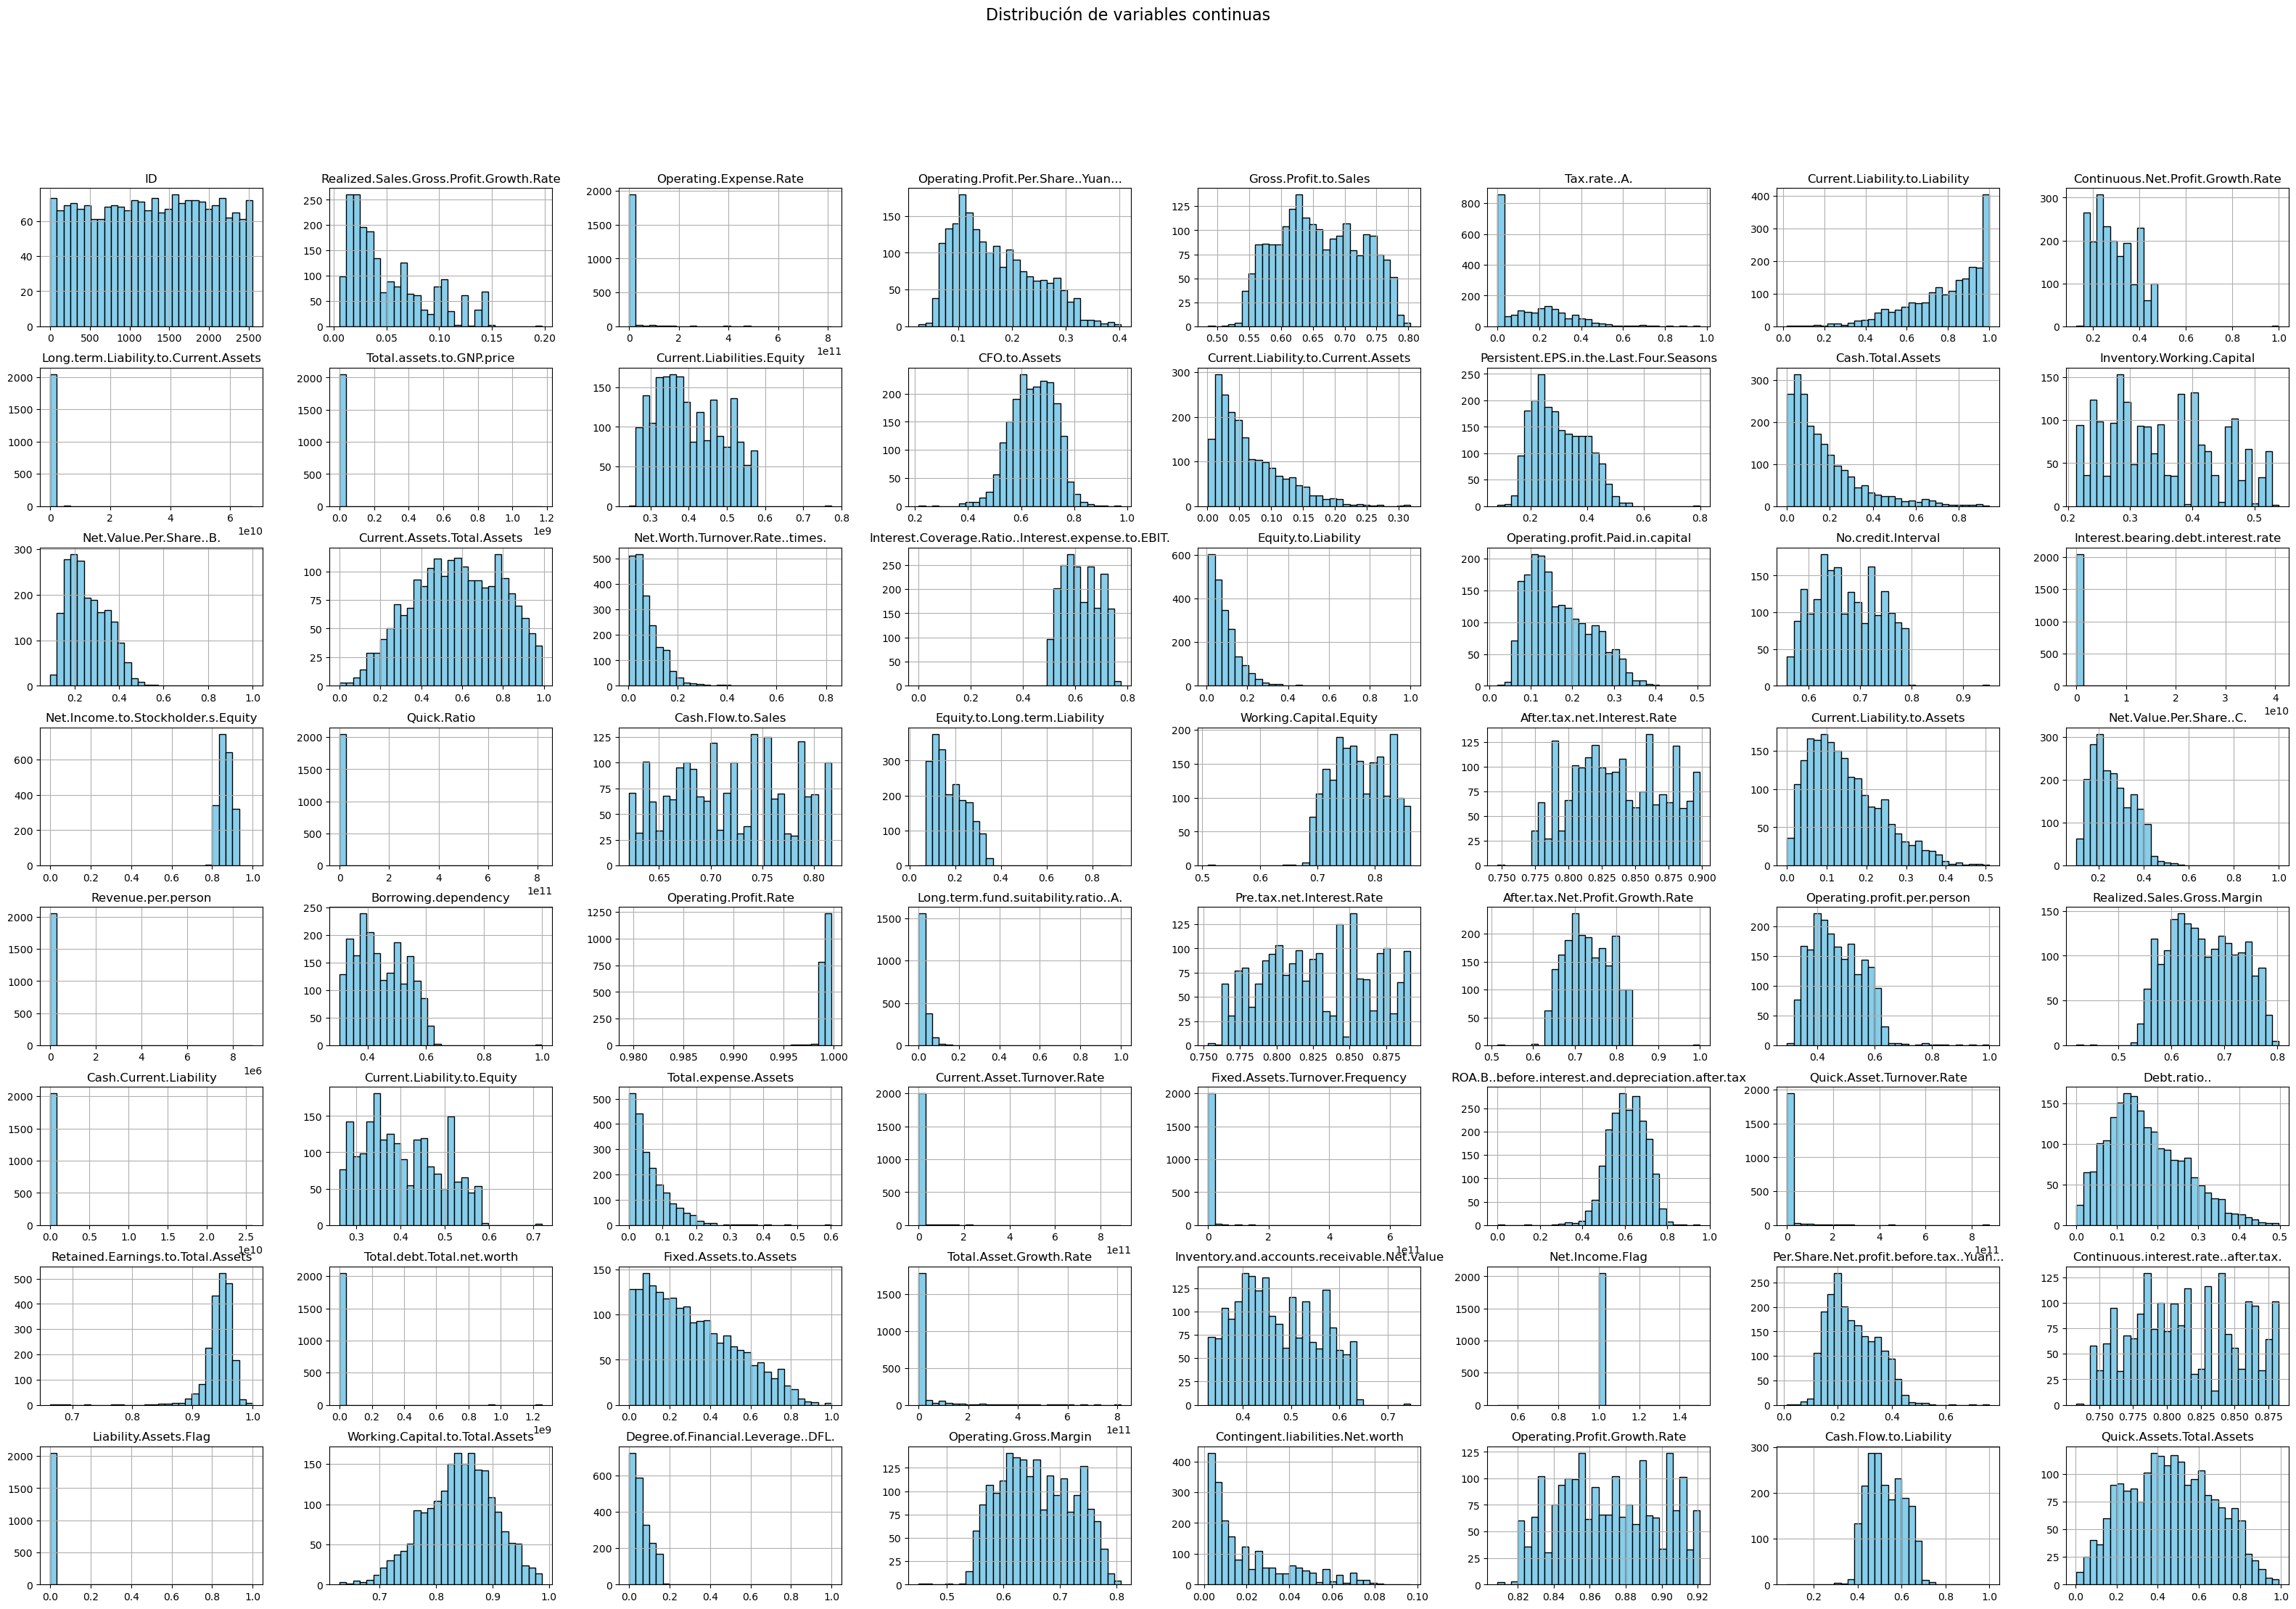

In [8]:
# Histogramas de las variables continuas
x.hist(bins=30, figsize=(40, 25), color='skyblue', edgecolor='black')
plt.suptitle("Distribución de variables continuas", fontsize=16)
plt.show()

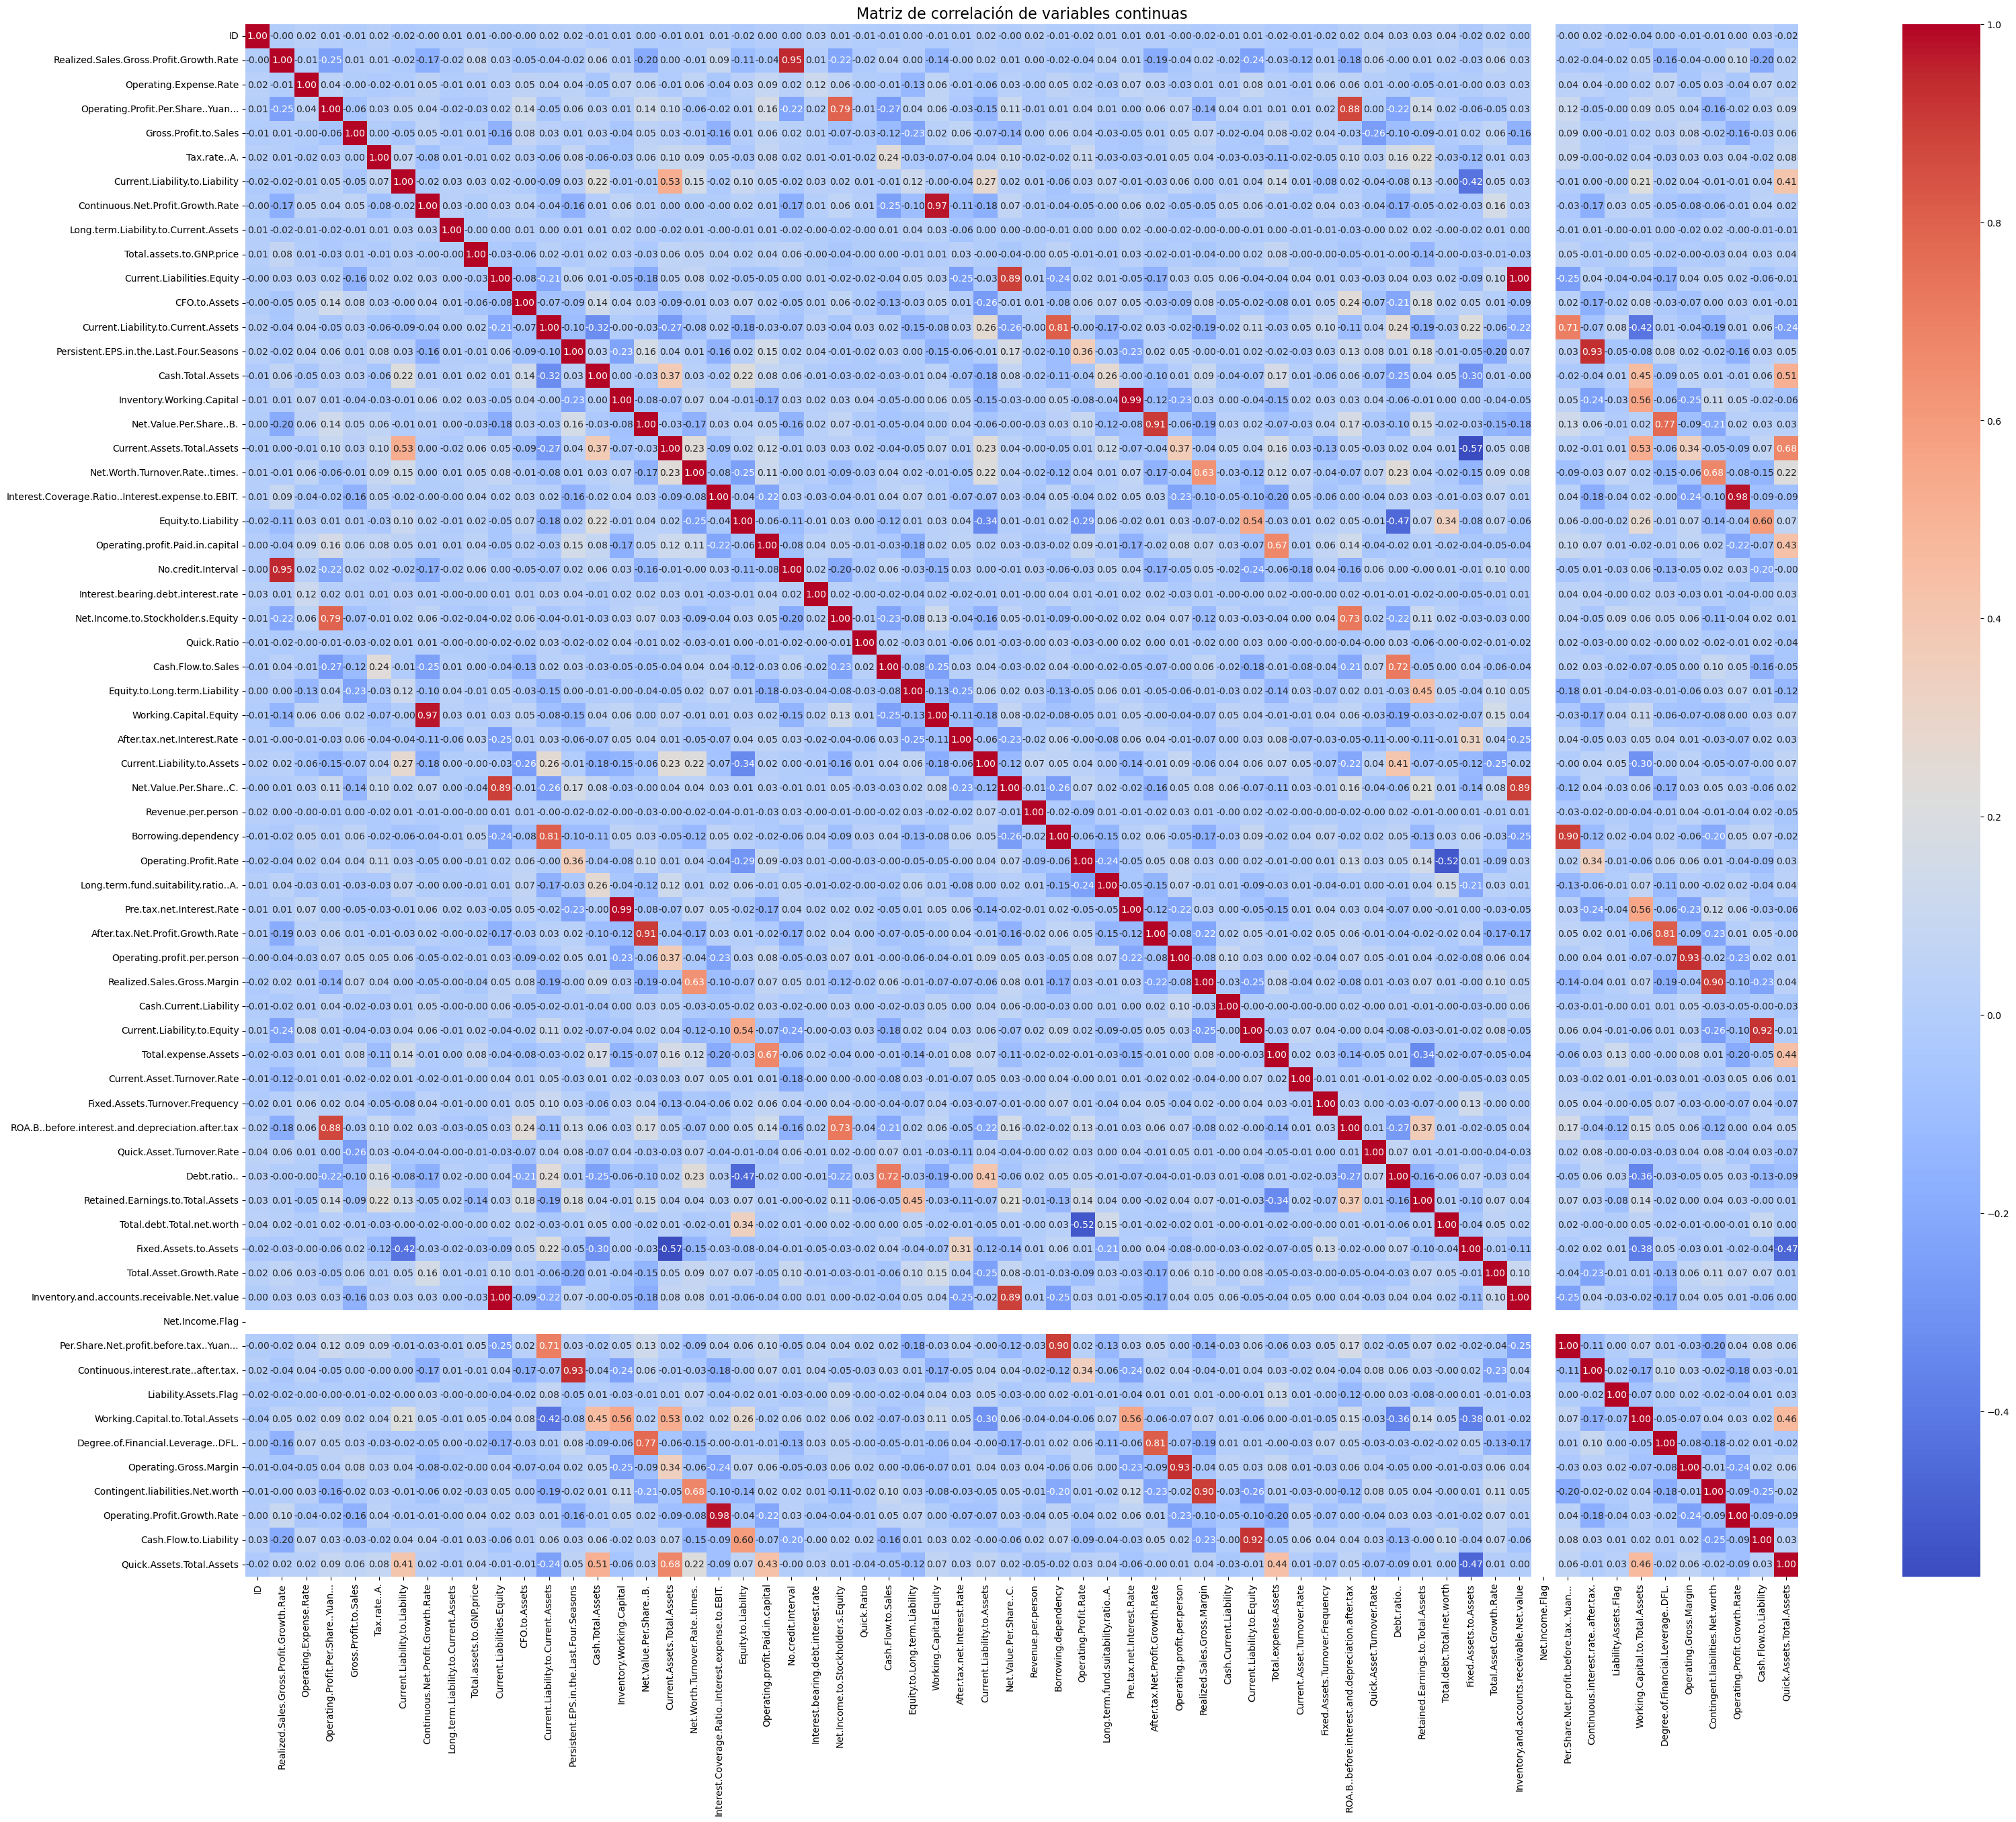

In [9]:
# Correlograma (matriz de correlación)
plt.figure(figsize=(40, 30))
correlation_matrix = x.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de correlación de variables continuas", fontsize=16)
plt.show()

C:\Users\cesar\AppData\Local\Temp\ipykernel_20072\3773259607.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


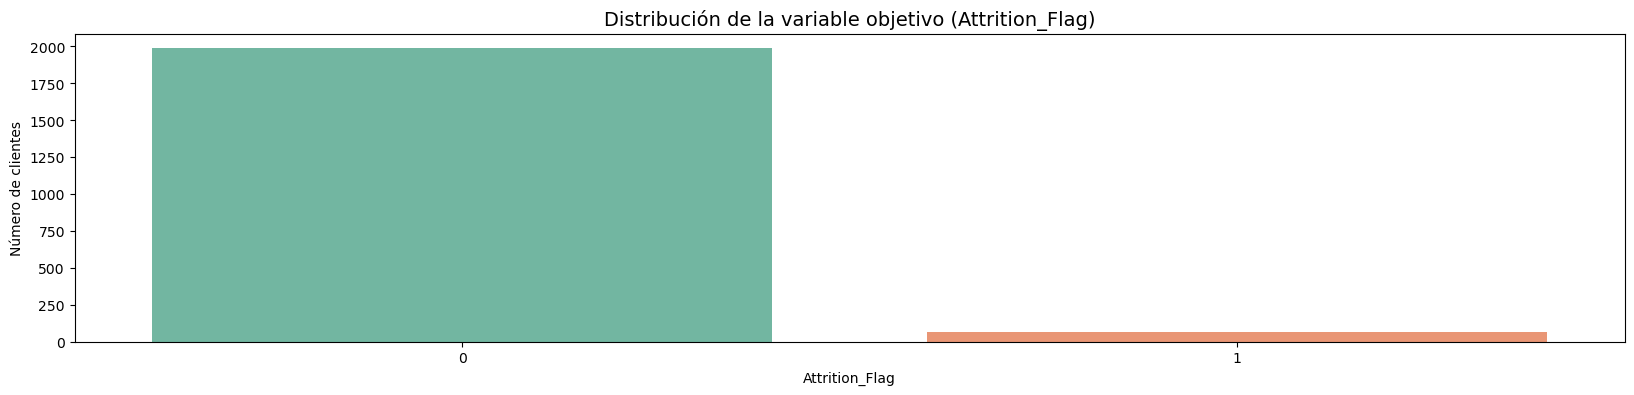

In [10]:
# Distribución de la variable objetivo
plt.figure(figsize=(20, 4))
sns.countplot(x=y, palette="Set2")
plt.title("Distribución de la variable objetivo (Attrition_Flag)", fontsize=14)
plt.xlabel("Attrition_Flag")
plt.ylabel("Número de clientes")
plt.xticks(rotation=0)
plt.show()

### Estimación del modelo usando una red neuronal con keras

In [11]:
# Se separan los datos en test y train
X_train_full, X_test, y_train_full, y_test = train_test_split(x, y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

# Se realiza el escalamiento de los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Transformar a formato NumPy
X_train = np.array(X_train, dtype=np.float32)
X_valid = np.array(X_valid, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

y_train = np.array(y_train, dtype=np.float32)
y_valid = np.array(y_valid, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [36]:
# Cracion de la red 
model = keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Dense(900, activation="relu", input_shape=(64,), kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(500, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(200, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(50, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation="sigmoid"))

C:\Users\cesar\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Generamos un resumen del modelo
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 900)                 │          58,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 900)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 500)                 │         450,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 200)                 │         100,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 50)                  │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 619,301 (2.36 MB)

 Trainable params: 619,301 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Compilacion del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
# Callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

In [40]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9373 - loss: 1.3463 - val_accuracy: 0.9662 - val_loss: 1175314432.0000
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9696 - loss: 0.8956 - val_accuracy: 0.9662 - val_loss: 1359457024.0000
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9687 - loss: 0.6684 - val_accuracy: 0.9610 - val_loss: 1546643584.0000
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9802 - loss: 0.5208 - val_accuracy: 0.9610 - val_loss: 1654318208.0000
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9638 - loss: 0.4327 - val_accuracy: 0.9558 - val_loss: 1598171648.0000
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9838 - loss: 0.3452 - val_accuracy: 0.9558 - val_loss: 2620287488.0000
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9822 - loss: 0.2939 - val_accuracy: 0.9558 - val_loss: 2255656960.0000
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc

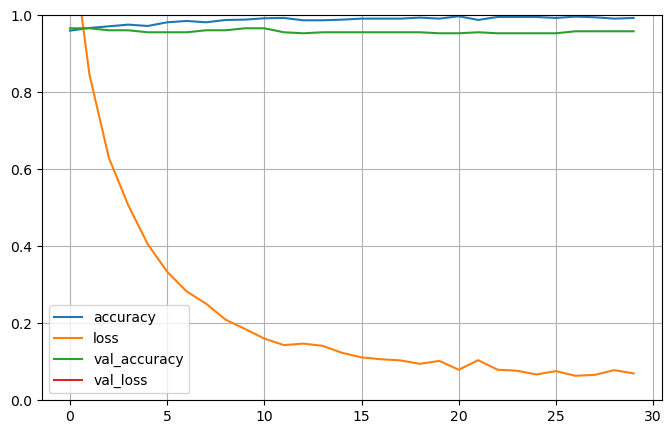

In [41]:
# graficar el entrenamiento del modelo
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

### Evaluacion del modelo

In [42]:
# evaluacion
test_loss, test_acc = model.evaluate(X_test, y_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9736 - loss: 0.1702 


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
El accuracy del modelo es: 0.9688109161793372
La precisión del modelo es: 0.3333333333333333
La matriz de confusión es: 
[[493   8]
 [  8   4]]
El AUC del modelo es: 0.9043579507651364


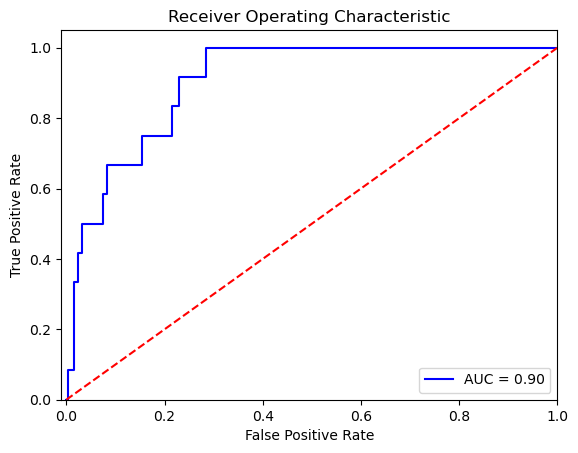

In [43]:
# Hallar probabilidades y clasificación que predice el modelo con threshold de 0.5
predicciones = model.predict(X_test)
y_pred = [round(x[0]) for x in predicciones]
# Imprimir métricas de desempeño
print("El accuracy del modelo es: "+str(accuracy_score(y_true=y_test, y_pred=y_pred)))
print("La precisión del modelo es: "+str(precision_score(y_true=y_test, y_pred=y_pred)))
print("La matriz de confusión es: \n"+str(confusion_matrix(y_true=y_test, y_pred=y_pred)))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicciones, pos_label=1)
AUCRegLog=metrics.auc(fpr, tpr)
print("El AUC del modelo es: "+str(AUCRegLog))

# Graficar curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCRegLog)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Calibración por hiperparámetros

In [106]:
# Se separan los datos en test y train
X_train_full, X_test, y_train_full, y_test = train_test_split(x, y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

# Se realiza el escalamiento de los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Transformar a formato NumPy
X_train = np.array(X_train, dtype=np.float32)
X_valid = np.array(X_valid, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

y_train = np.array(y_train, dtype=np.float32)
y_valid = np.array(y_valid, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [107]:
# Penalizacion L1
model1 = Sequential()
model1.add(Dense(256, input_dim=64, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
model1.add(Dense(128, activation='relu',  kernel_regularizer=regularizers.l1(0.0001)))
model1.add(Dense(1, activation='sigmoid'))

C:\Users\cesar\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [108]:
# Penalizacion L2
model2 = Sequential()
model2.add(Dense(128, input_dim=64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model2.add(Dense(64, activation='relu',  kernel_regularizer=regularizers.l2(0.001)))
model2.add(Dense(1, activation='sigmoid'))

In [109]:
# Dropout
modeldp = Sequential()
modeldp.add(Dense(64, activation='relu'))
modeldp.add(Dropout(0.03))
modeldp.add(Dense(1, activation='sigmoid'))

In [110]:
# Early Stopping
modeles = Sequential()
modeles.add(Dense(128, input_dim=64, activation='relu'))
modeles.add(Dense(64, activation='relu'))
modeles.add(Dense(1, activation='sigmoid'))

In [111]:
# Compilación de modelos
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modeldp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modeles.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [112]:
# Entrenamiento de modelos
history=model.fit(X_train, y_train, epochs=40, batch_size=10 )
history1=model1.fit(X_train, y_train, epochs=40, batch_size=10 )
history2=model2.fit(X_train, y_train, epochs=40, batch_size=10 )
historydp=modeldp.fit(X_train, y_train, epochs=40, batch_size=10 )
historyes=modeles.fit(X_train, y_train, epochs=40, batch_size=10 , callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9875 - loss: 0.0691
Epoch 2/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9810 - loss: 0.0843
Epoch 3/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9822 - loss: 0.0781
Epoch 4/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9756 - loss: 0.0892
Epoch 5/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.0575
Epoch 6/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9769 - loss: 0.0754
Epoch 7/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0513
Epoch 8/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0472
Epoch 9/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9853 - loss: 0.0493
Epoch 10/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0504
Epoch 11/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0482
Epoch 12/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

C:\Users\cesar\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.9639 - loss: 0.0923
Epoch 4/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.9813 - loss: 0.0531
Epoch 5/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.9868 - loss: 0.0392
Epoch 6/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.9860 - loss: 0.0396
Epoch 7/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.9896 - loss: 0.0289
Epoch 8/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.9929 - loss: 0.0233
Epoch 9/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.9878 - loss: 0.0210 
Epoch 10/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.9966 - loss: 0.0170 
Epoch 11/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.9983 - loss: 0.0114
Epoch 12/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.9994 - loss: 0.0093
Epoch 13/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.9997 - loss: 0.0085
Epoch 14/40
116/116 ━━━━━━━━━━━━━━━━━

In [113]:
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

_, accuracy = model1.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

_, accuracy = model2.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

_, accuracy = modeldp.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

_, accuracy = modeles.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9993 - loss: 0.0312  
Accuracy: 99.83
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9991 - loss: 0.0274 
Accuracy: 99.91
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.9953 - loss: 0.0392
Accuracy: 99.65
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0069 
Accuracy: 100.00
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.9991 - loss: 0.0013   
Accuracy: 99.91


In [114]:
#Predicciones
predicciones = model.predict(X_test)
redondeado = [round(x[0]) for x in predicciones]
predicciones = (model.predict(X_test) > 0.5).astype(int)

predicciones1 = model1.predict(X_test)
redondeado1 = [round(x[0]) for x in predicciones1]
predicciones1 = (model1.predict(X_test) > 0.5).astype(int)

predicciones2 = model2.predict(X_test)
redondeado2 = [round(x[0]) for x in predicciones2]
predicciones2 = (model2.predict(X_test) > 0.5).astype(int)

prediccionesdp = modeldp.predict(X_test)
redondeadodp = [round(x[0]) for x in predicciones]
prediccionesdp = (modeldp.predict(X_test) > 0.5).astype(int)


prediccioneses = modeles.predict(X_test)
redondeadoes = [round(x[0]) for x in prediccioneses]
prediccioneses = (modeles.predict(X_test) > 0.5).astype(int)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step


In [115]:
# Acurracy
test_loss, test_acc = model.evaluate(X_test, y_test)
test_loss1, test_acc1 = model1.evaluate(X_test, y_test)
test_loss2, test_acc2 = model2.evaluate(X_test, y_test)
test_lossdp, test_accdp = modeldp.evaluate(X_test, y_test)
test_losses, test_acces = modeles.evaluate(X_test, y_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9859 - loss: 107589.9844
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9767 - loss: 110456.9688
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9779 - loss: 4243675.5000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9841 - loss: 56810.9297
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9783 - loss: 11180262.0000


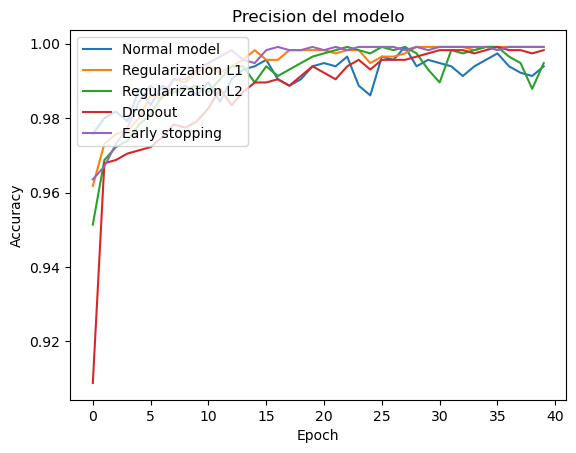

In [116]:
plt.figure(1)
# Graficar accuracy del modelo
plt.title('Precision del modelo')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(history.history['accuracy'])
plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(historydp.history['accuracy'])
plt.plot(historyes.history['accuracy'])
plt.legend(['Normal model', 'Regularization L1', 'Regularization L2', 'Dropout', 'Early stopping' ], loc='upper left')
plt.show()

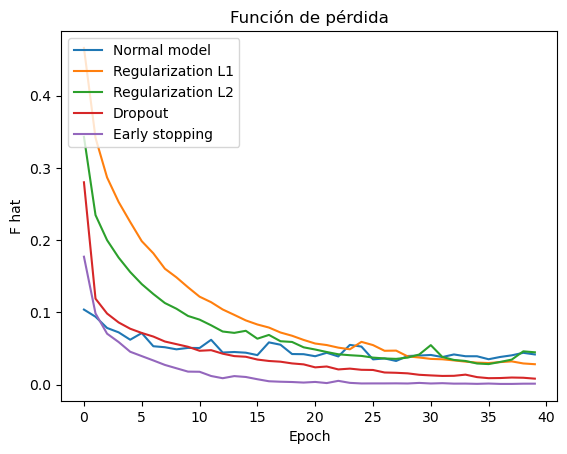

In [117]:
# Graficar la función de pérdida evaluada
plt.title('Función de pérdida')
plt.ylabel('F hat')
plt.xlabel('Epoch')
plt.plot(history.history['loss'])
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(historydp.history['loss'])
plt.plot(historyes.history['loss'])
plt.legend(['Normal model', 'Regularization L1', 'Regularization L2', 'Dropout', 'Early stopping' ], loc='upper left')
plt.show()

In [123]:
# Grid search

l2_values = [0.0, 0.001, 0.005, 0.01]
neurons1 = [32, 64, 128]
neurons2 = [20, 32, 64]
neurons3 = [8, 16, 32]
dropouts = [0.0, 0.2, 0.3]
batch_sizes = [10, 32, 64]

# Guardar resultados
results = []

# Configurar EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Grid Search manual
for l2, n1, n2, n3, d, bs in product(l2_values, neurons1, neurons2, neurons3, dropouts, batch_sizes):
    model = Sequential()
    model.add(Dense(n1, input_dim=64, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    if d > 0:
        model.add(Dropout(d))
    model.add(Dense(n2, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    if d > 0:
        model.add(Dropout(d))
    model.add(Dense(n3, activation='relu', kernel_regularizer=regularizers.l2(l2)))  # <- tercera capa
    if d > 0:
        model.add(Dropout(d))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, 
                        epochs=50, 
                        batch_size=bs, 
                        validation_split=0.2, 
                        callbacks=[early_stop],
                        verbose=0)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    results.append({
        'L2': l2,
        'Neurons_1': n1,
        'Neurons_2': n2,
        'Neurons_3': n3,
        'Dropout': d,
        'Batch_size': bs,
        'Test_Accuracy': test_acc,
        'Best_Epochs': len(history.history['loss'])
    })

# Convertir a DataFrame para ver los resultados ordenados
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Test_Accuracy', ascending=False).head(10))

C:\Users\cesar\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


        L2  Neurons_1  Neurons_2  Neurons_3  Dropout  Batch_size  \
263  0.001         32         20         32      0.0          64   
466  0.001        128         64          8      0.3          32   
441  0.001        128         32         16      0.0          10   
554  0.005         32         64         16      0.2          64   
443  0.001        128         32         16      0.0          64   
400  0.001         64         64         32      0.2          32   
461  0.001        128         64          8      0.0          64   
635  0.005         64         64         16      0.2          64   
462  0.001        128         64          8      0.2          10   
261  0.001         32         20         32      0.0          10   

     Test_Accuracy  Best_Epochs  
263       0.980507           19  
466       0.980507           11  
441       0.980507            9  
554       0.980507           50  
443       0.978558           13  
400       0.978558           12  
461       0.9

# Modelo con mejor desempeño

In [192]:
# Se separan los datos en test y train
X_train_full, X_test, y_train_full, y_test = train_test_split(x, y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

# Se realiza el escalamiento de los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Transformar a formato NumPy
X_train = np.array(X_train, dtype=np.float32)
X_valid = np.array(X_valid, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

y_train = np.array(y_train, dtype=np.float32)
y_valid = np.array(y_valid, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [193]:
# Modelo con hiperparámetros óptimos
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.001)))
#model.add(Dropout(0.3))
model.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
#model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
#model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


C:\Users\cesar\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [194]:
# Compilación
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [195]:
# Entrenamiento
history = model.fit(X_train, y_train, epochs=19, batch_size=64, validation_data=(X_test, y_test), verbose=1)


Epoch 1/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4945 - loss: 0.8121 - val_accuracy: 0.9649 - val_loss: 23409.5039
Epoch 2/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9749 - loss: 0.4245 - val_accuracy: 0.9649 - val_loss: 44719.7070
Epoch 3/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9712 - loss: 0.2728 - val_accuracy: 0.9649 - val_loss: 62051.6094
Epoch 4/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9758 - loss: 0.2109 - val_accuracy: 0.9649 - val_loss: 73751.9453
Epoch 5/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9753 - loss: 0.1915 - val_accuracy: 0.9649 - val_loss: 76930.3750
Epoch 6/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9745 - loss: 0.2023 - val_accuracy: 0.9649 - val_loss: 78583.6641
Epoch 7/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9783 - loss: 0.1675 - val_accuracy: 0.9649 - val_loss: 82070.4219
Epoch 8/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9719 - loss: 0.1721 - val

In [196]:
# Evaluación
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.9649


In [197]:
# Predicciones
predicciones = model.predict(X_test)
predicciones = (predicciones > 0.5).astype(int)



17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


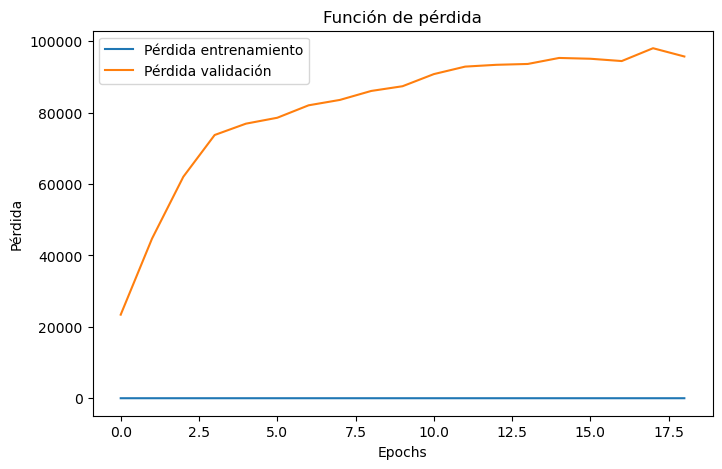

In [198]:
# Gráfica de función de pérdida
plt.figure(figsize=(8,5))
plt.title('Función de pérdida')
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
El accuracy del modelo es: 0.9649122807017544
La precisión del modelo es: 0.0
La matriz de confusión es: 
[[495   0]
 [ 18   0]]
El AUC del modelo es: 0.8060606060606059


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


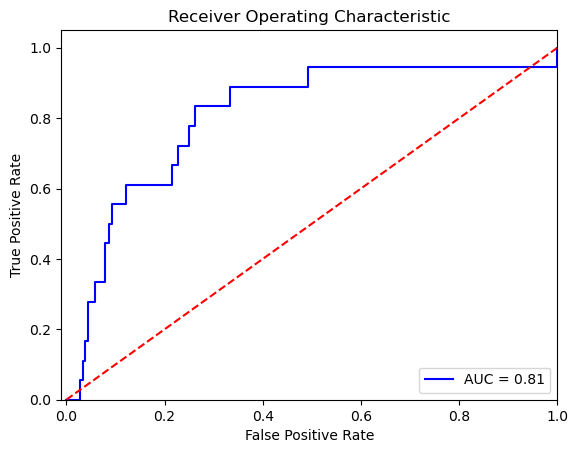

In [199]:
# Hallar probabilidades y clasificación que predice el modelo con threshold de 0.5
predicciones = model.predict(X_test)
y_pred = [round(x[0]) for x in predicciones]
# Imprimir métricas de desempeño
print("El accuracy del modelo es: "+str(accuracy_score(y_true=y_test, y_pred=y_pred)))
print("La precisión del modelo es: "+str(precision_score(y_true=y_test, y_pred=y_pred)))
print("La matriz de confusión es: \n"+str(confusion_matrix(y_true=y_test, y_pred=y_pred)))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicciones, pos_label=1)
AUCRegLog=metrics.auc(fpr, tpr)
print("El AUC del modelo es: "+str(AUCRegLog))

# Graficar curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCRegLog)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Prediccion de nuevos datos

In [ ]:
# Cargar Datos de prueba
df_test = pd.read_csv('test_data.csv')

# vista previa
df_test.head()

In [189]:
# Se realiza el escalamiento de los datos
scaler = StandardScaler()
df_test_Scaler = scaler.fit_transform(df_test)

# Transformar a formato NumPy
df_test_Scaler = np.array(df_test_Scaler, dtype=np.float32)

In [190]:
# Precir nuevos datos
y_predict = model.predict(df_test)
y_predict = [round(x[0]) for x in y_predict]

resultado = pd.DataFrame({'id': df_test['ID'].values, 'prediccion': y_predict})
resultado.head()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,id,prediccion
0,5,0
1,14,0
2,16,0
3,26,0
4,28,0


In [191]:
# Crear csv con las predicciones
resultado.rename(columns={'id':'ID'}, inplace=True)
resultado.rename(columns={'prediccion':'Bankruptcy'}, inplace=True)

resultado.to_csv('submission.csv', index=False)